In [238]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from collections import Counter
from sklearn.neighbors import KernelDensity
from matplotlib import colormaps
from scipy.stats import pearsonr, spearmanr, gaussian_kde, kruskal,  multivariate_normal as mvn
from sklearn.metrics import mutual_info_score, confusion_matrix
from sklearn.feature_selection import mutual_info_regression
from scipy.spatial.distance import jensenshannon
from scipy.io import loadmat
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import preprocessing

In [ ]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install scipy
!pip install scikit-learn


# 2: Density estimation: Psychological experiments

In [6]:
# read in the data

df = pd.read_csv('./data/n90pol.csv')
df

amygdala     acc  orientation
0     0.0051 -0.0286            2
1    -0.0674  0.0007            3
2    -0.0257 -0.0110            3
3     0.0504 -0.0167            2
4     0.0125 -0.0005            5
..       ...     ...          ...
85    0.0174 -0.0242            2
86    0.0251 -0.0087            3
87    0.0676  0.0120            2
88   -0.0097 -0.0239            3
89    0.0374  0.0502            3

[90 rows x 3 columns]

In [298]:
# visualize the data for part 1
h_amygdala = 1.06*df.std().iloc[0]*len(df)**(-1/5)
h_acc = 1.06*df.std().iloc[1]*len(df)**(-1/5)

def plot_hist_and_kde(data, bandwidth, num_bins = 10):
    plt.figure(figsize=(12, 5))
    
    
    # histogram
    plt.subplot(1, 2, 1)
    sns.histplot(data, color='blue',bins= num_bins)
    plt.title(f'{data.name} - histogram')
    
    #kde
    plt.subplot(1, 2, 2)
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    xplot = np.linspace(-0.1, 0.1, 1000)[:, np.newaxis]
    data_kde = kde.fit(np.array(data).reshape(-1, 1))
    log_dens_data = kde.score_samples(xplot)
    plt.plot(np.exp(log_dens_data))
    plt.title(f'{data.name} - KDE')
    
    plt.savefig(f'./outputs/{data.name}.png')
    
    plt.show()
    

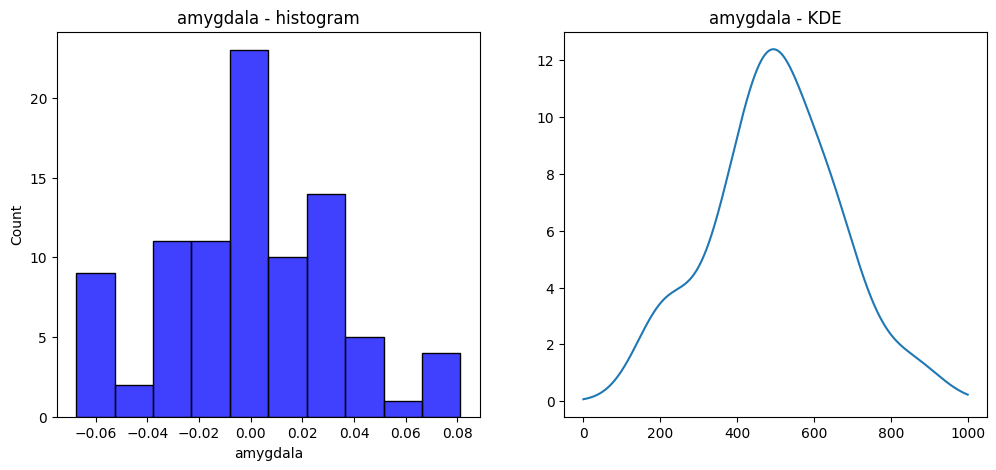

In [299]:
plot_hist_and_kde(df['amygdala'], bandwidth = h_amygdala)

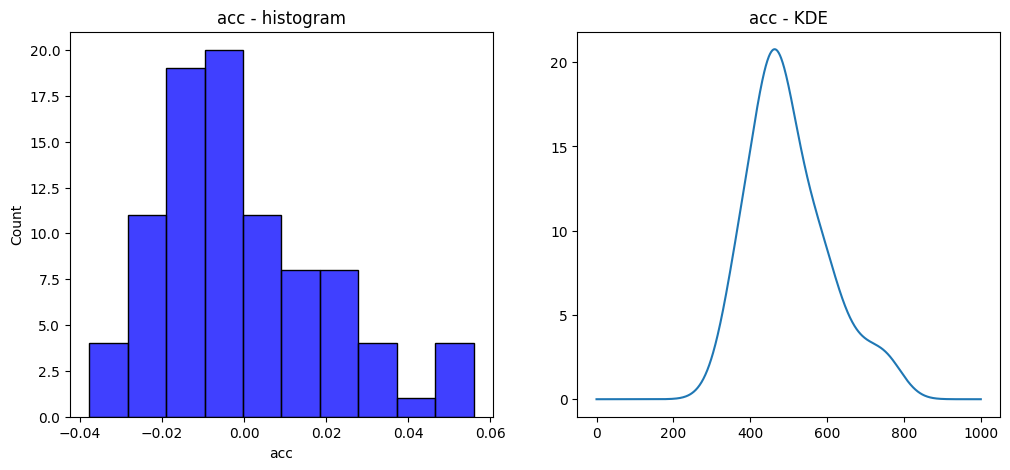

In [300]:
plot_hist_and_kde(df['acc'], bandwidth=h_acc)

In [328]:
# now for part 2: plot 2 dimensional histogram of acc with amygdala choosing appropriate num of bins
def two_dim_hist(data1, data2, num_bins = 20):
    plt.figure(figsize=(8, 6))
    plt.hist2d(data1, data2, bins=10, cmap='Blues')
    plt.colorbar()
    plt.title('2D Histogram of Amygdala and ACC')
    plt.xlabel(f'{data1.name}')
    plt.ylabel(f'{data2.name}')
    
    plt.savefig(f'./outputs/2D Histogram of Amygdala and ACC.png')
    plt.show()

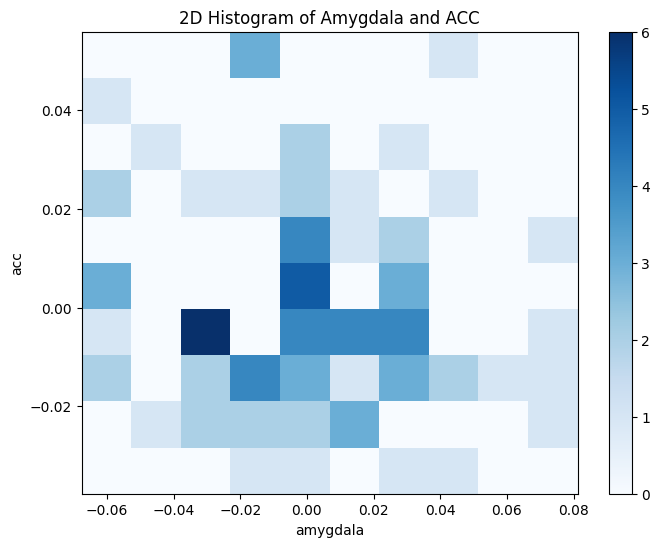

In [329]:
# plot
two_dim_hist(df['amygdala'], df['acc'])

In [303]:
# create a 3d plot representation
def plot_3d(data1, data2, num_bins = (10,10)):
    # Set up the figure and 3D axis
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    # reshape into numpy arrays for easier use
    x = np.array(data1).reshape(len(data1))
    y = np.array(data2).reshape(len(data2))
    
    # Create histogram data
    hist, xedges, yedges = np.histogram2d(x, y, bins=num_bins)
    
    # Construct arrays for the bars
    xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:])
    xpos = xpos.flatten()/2
    ypos = ypos.flatten()/2
    zpos = np.zeros_like(ypos)
    
    # Size of the bars
    dx = xedges [1] - xedges [0]
    dy = yedges [1] - yedges [0]
    dz = hist.flatten()
    
    cmap = plt.get_cmap('Blues') 
    max_height = np.max(dz) 
    min_height = np.min(dz)
    
    color_map = [cmap((k-min_height)/max_height) for k in dz] 
    
    # Plot bars
    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color = color_map, zsort='average')
    
    # Set labels
    ax.set_xlabel(f'{data1.name}')
    ax.set_ylabel(f'{data2.name}')
    ax.set_zlabel('Frequency')
    ax.set_title(f'3D Histogram of {data1.name} and {data2.name}')
    
    plt.savefig(f'./outputs/3D Histogram.png')
    
    plt.show()

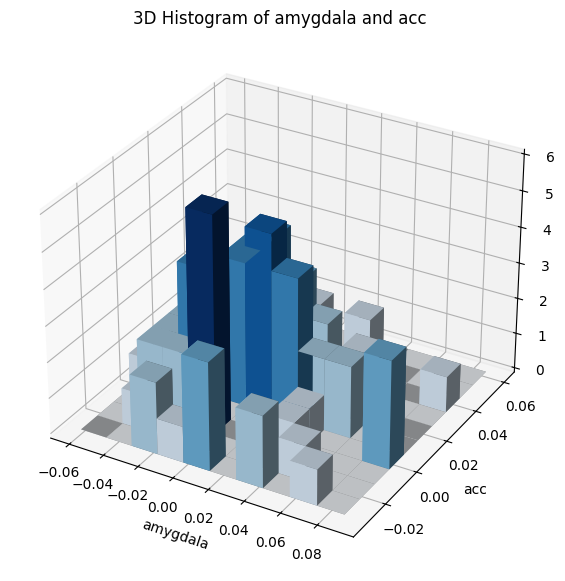

In [304]:
plot_3d(df['amygdala'], df['acc'])

In [305]:
# part 3: estimate kde using silverman's method
# https://stackoverflow.com/questions/30145957/plotting-2d-kernel-density-estimation-with-python

def kde_plot(data1, data2):
    
    x = np.array(data1).reshape(len(data1))
    y = np.array(data2).reshape(len(data2))
    
    xmin, xmax = round(x.min(),2) - 0.01, round(x.max(),2) + 0.01
    ymin, ymax = round(y.min(),2) - 0.01, round(y.max(),2) + 0.01
    
    # perform KDE
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    kernel = gaussian_kde(values, bw_method = 'silverman')
    
    f = np.reshape(kernel(positions).T, xx.shape)
    
    fig = plt.figure()
    ax = fig.gca()
    
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    # Contourf plot
    cfset = ax.contourf(xx, yy, f, cmap='Blues')
    
    # Contour plot
    cset = ax.contour(xx, yy, f, colors='k')
    
    ax.plot(x,y, '*', markersize = 1, color = 'black')
    
    # Label plot
    ax.clabel(cset, inline=1, fontsize=10)
    ax.set_xlabel(f'{data1.name}')
    ax.set_ylabel(f'{data2.name}')
    
    plt.savefig(f'./outputs/kde.png')
    
    plt.show()
    
    

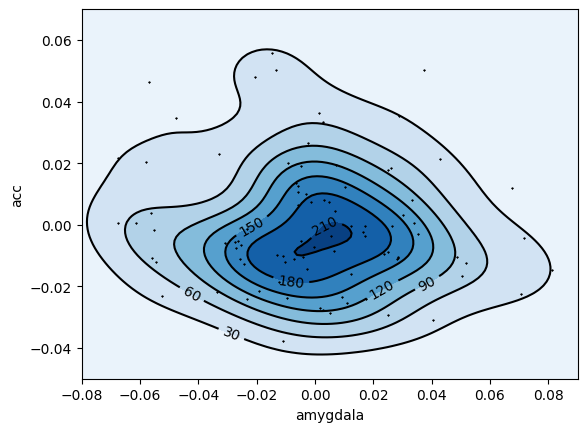

In [306]:
kde_plot(df['amygdala'], df['acc'])

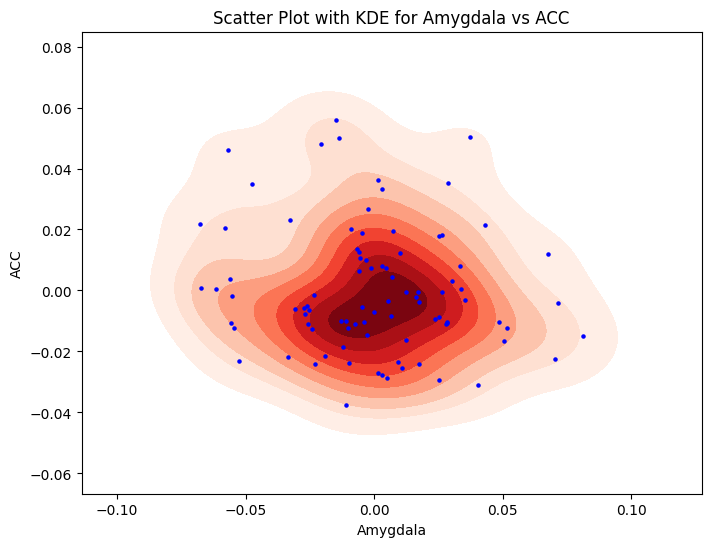

In [307]:
#KDE plot using seaborn implementation with Silverman method for binwidth estimation

plt.figure(figsize=(8,6))
sns.kdeplot(x=df['amygdala'], y=df['acc'], bw_method = 'silverman', cmap='Reds', fill=True)
plt.scatter(df['amygdala'], df['acc'], c='blue', s=5)  
plt.xlabel('Amygdala')
plt.ylabel('ACC')
plt.title('Scatter Plot with KDE for Amygdala vs ACC')
plt.savefig('./outputs/kde2.png')
plt.show()

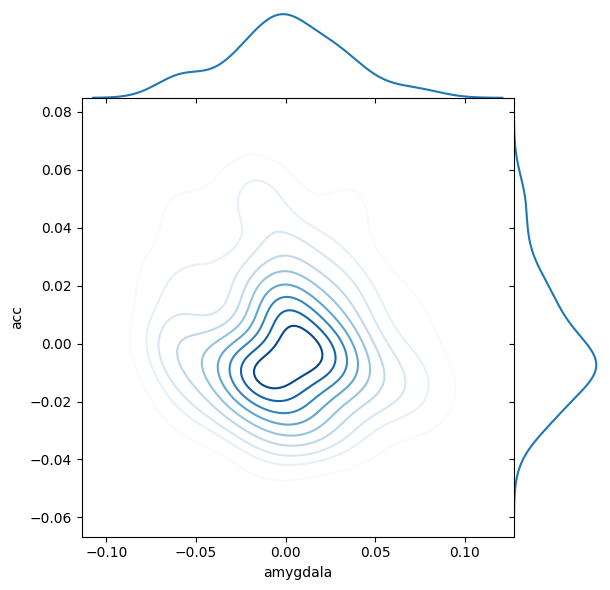

In [330]:
# plot the joint distribution with marginal histogram
sns.jointplot(data=df, x='amygdala', y='acc', kind='kde', bw_method = 'silverman',cmap='Blues', space=0)
plt.savefig('./outputs/jointplot.png')
plt.show()

In [89]:
# calculate the Pearson Correlation 
corr, p_value = pearsonr(df['amygdala'], df['acc'])
print(f"Pearson Correlation: {corr}, P-value: {p_value}")

# high p value, fail to reject null. Most likely isn't a statistically significant linear relationship

Pearson Correlation: -0.1284840320498912, P-value: 0.2274792595627118


In [93]:
# using spearman correlation (ignore linear rel)
spearman_corr, spearman_p_value = spearmanr(df['amygdala'], df['acc'])
print(f"Spearman Correlation: {spearman_corr}, P-value: {spearman_p_value}")

# high p value fails to reject the null and therefore there isn't a statistically significant monotonic relationship

Spearman Correlation: -0.1007577410393683, P-value: 0.34470088504373364


In [105]:
def calc_mutual_info(data1, data2):
    mi_score = mutual_info_regression(data1.values.reshape(-1, 1), data2.values)
    return mi_score[0]

# Assuming 'amygdala' and 'acc' are columns in a pandas dataframe df:
mi_score = calc_mutual_info(df['amygdala'], df['acc'])
print(f'Mutual Information Score: {mi_score}')

# not equal to 0 means not independent, very small information gained

Mutual Information Score: 0.20016354380416335


In [109]:
# Estimate KDEs
kde_x = gaussian_kde(df['amygdala'])
kde_y = gaussian_kde(df['acc'])
joint_kde = gaussian_kde(np.vstack([df['amygdala'], df['acc']]))

# Get grid for comparison
grid_x = np.linspace(df['amygdala'].min(), df['amygdala'].max(), 100)
grid_y = np.linspace(df['acc'].min(), df['acc'].max(), 100)

# Marginal densities
px = kde_x(grid_x)
py = kde_y(grid_y)

# Joint density
p_joint = joint_kde(np.vstack([grid_x, grid_y]))

# Compute Jensen-Shannon divergence
js_divergence = jensenshannon(px, py)
print(f'Jensen-Shannon Divergence: {js_divergence}')

#somewhat similar but noticeable diff: 0-1 range

Jensen-Shannon Divergence: 0.14233547720753623


In [311]:
# define function to plot kde of each data based on values of orientation


def plot_by_orientation(data1_name, data2 = df):
    
    plt.figure(figsize=(6, 4))
    
    sns.kdeplot(data = data2, x = data1_name, bw_method = 'silverman', hue = df['orientation'])
    plt.title(f'KDE Plot - {data1_name}')
    plt.savefig(f'./outputs/{data1_name}-orientation.png')
    plt.show()

    

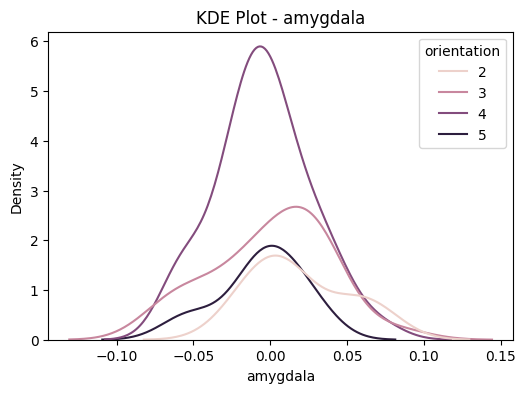

In [312]:
# plot for amygdala
plot_by_orientation('amygdala')

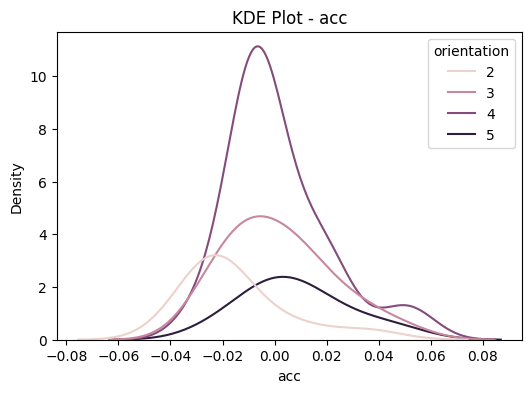

In [313]:
# plot for acc
plot_by_orientation('acc')

In [124]:
# print conditional means
conditional_means = df.groupby('orientation').agg({'amygdala': 'mean', 'acc': 'mean'}).reset_index()
print(conditional_means)

   orientation  amygdala       acc
0            2  0.019062 -0.014769
1            3  0.000588  0.001671
2            4 -0.004720  0.001310
3            5 -0.005692  0.008142


In [314]:
# create function to plot kde for joint distribution

def plot_joint_by_orientation(data1_name, data2_name, data = df):
    
    plt.figure(figsize=(12, 8))
    
    sns.kdeplot(data=data, x=data1_name, y=data2_name, bw_method = 'silverman', hue="orientation", fill = True, palette = 'bright')
    
    sns.scatterplot(data=data, x=data1_name, y=data2_name,  c= 'black', s = 10)
    plt.title(f'Joint KDE Plot')
    plt.xlabel(f'{data1_name}')
    plt.ylabel(f'{data2_name}')
    plt.savefig(f'./outputs/{data1_name}-{data2_name}.png')
    plt.show()

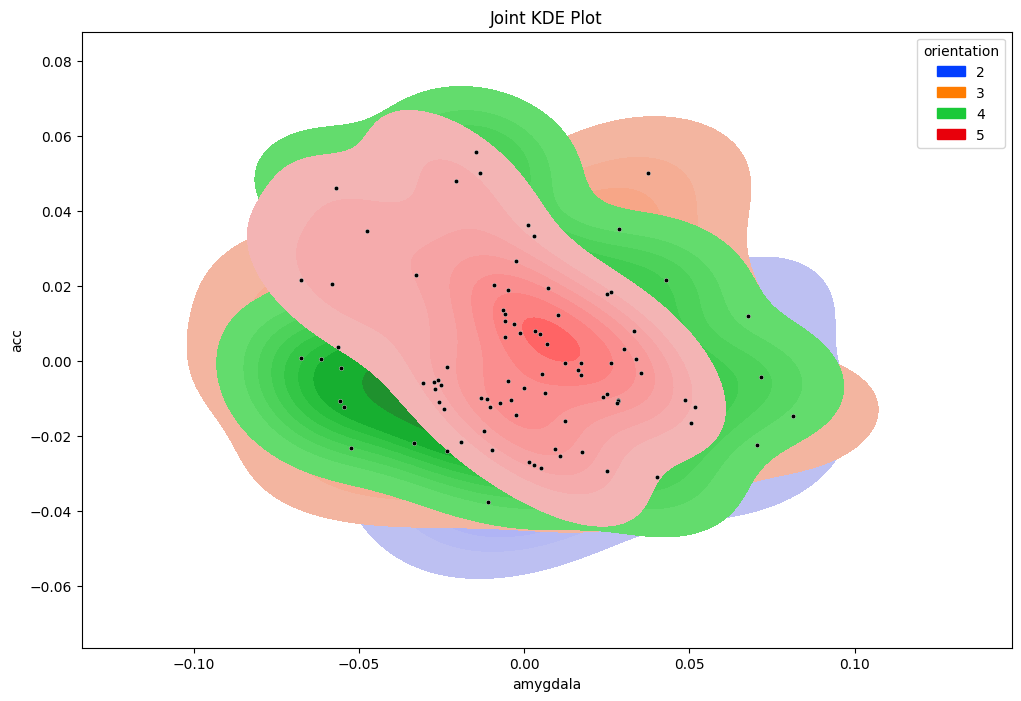

In [315]:
plot_joint_by_orientation('amygdala', 'acc')

In [316]:
def plot_joint_by_orientation_ind(data1_name, data2_name, data=df):
    orientations = data['orientation'].unique()
    
    # Set up the subplot grid
    num_orientations = len(orientations)
    fig, axes = plt.subplots(num_orientations, 1, figsize=(6, 18), sharex=True, sharey=True)
    
    for i, orientation in enumerate(orientations):
        subset = data[data['orientation'] == orientation]
        
        # Create a 2D KDE plot for each orientation
        sns.kdeplot(
            data=subset,
            x=data1_name,
            y=data2_name,
            bw_method='silverman',
            fill=True,
            ax=axes[i],
            color = 'red'
        )
        
        sns.scatterplot(data = subset, x = data1_name, y = data2_name, c='blue', s=5,ax=axes[i]) 
        
        axes[i].set_title(f'Joint KDE Plot (Orientation = {orientation})')
        axes[i].set_xlabel(f'{data1_name}')
        axes[i].set_ylabel(f'{data2_name}')
        
    plt.tight_layout()
    plt.savefig(f'./outputs/{data1_name}-{data2_name}-jointplot.png')
    plt.show()



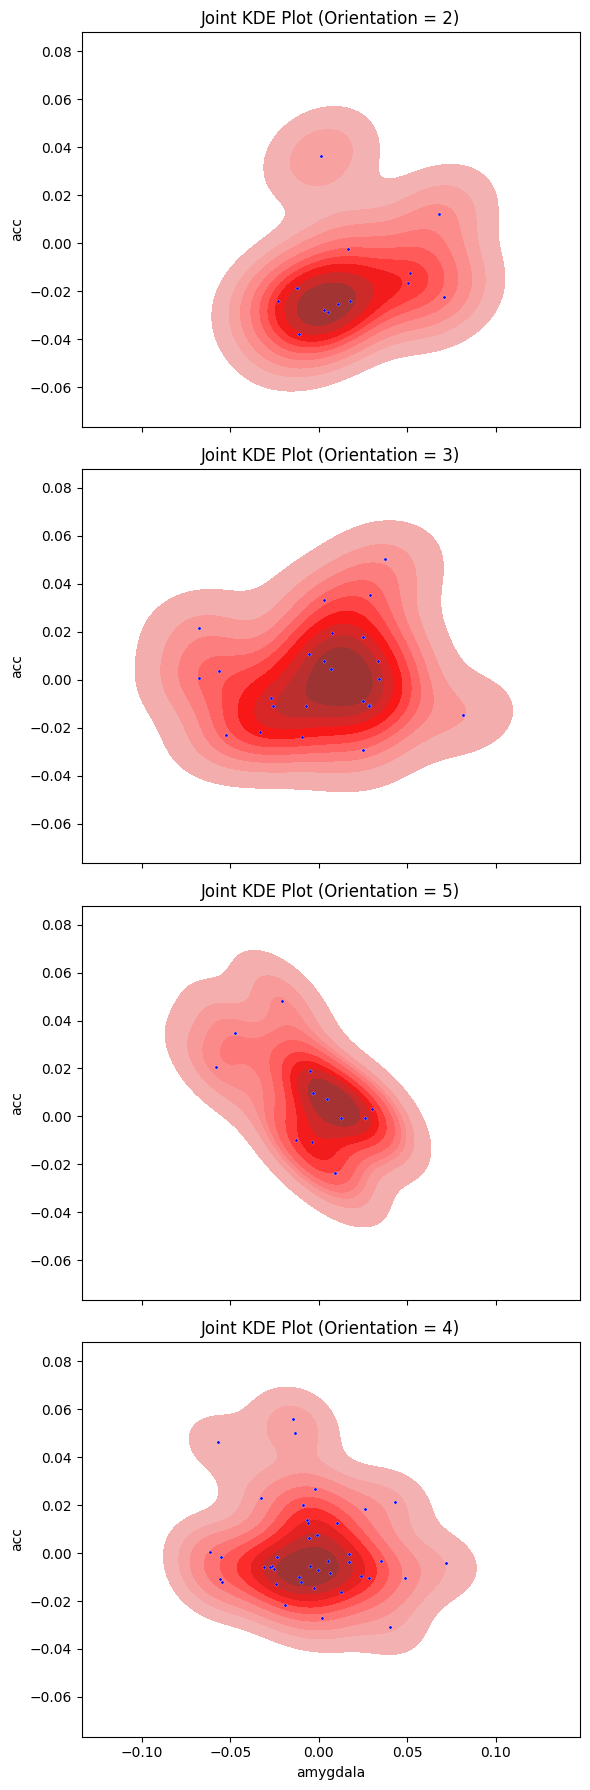

In [317]:
# Call the function with the variable names
plot_joint_by_orientation_ind('amygdala', 'acc')

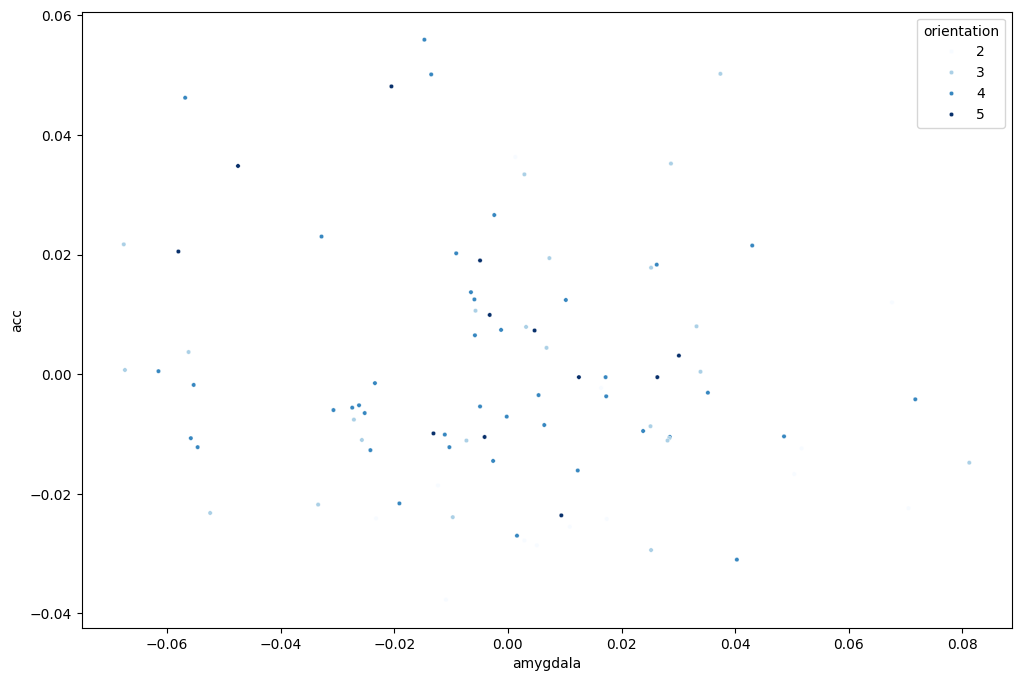

In [318]:
# just making the scatterplot to visualize the data

plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='amygdala', y='acc',  hue = 'orientation', palette = 'Blues', s = 10)
plt.savefig('./outputs/scatterplot.png')
plt.show()

In [203]:
# apply Kruskal-Wallis tets

# Prepare data for the test
groups_amygdala = [df[df['orientation'] == c]['amygdala'] for c in range(min(df['orientation']), max(df['orientation']) + 1)]
groups_acc = [df[df['orientation'] == c]['acc'] for c in range(min(df['orientation']), max(df['orientation']) + 1)]

# Perform Kruskal-Wallis test
kruskal_amygdala = kruskal(*groups_amygdala)
kruskal_acc = kruskal(*groups_acc)

print("Kruskal-Wallis Test for Amygdala: H-statistic =", kruskal_amygdala.statistic, ", p-value =", kruskal_amygdala.pvalue)
print("Kruskal-Wallis Test for ACC: H-statistic =", kruskal_acc.statistic, ", p-value =", kruskal_acc.pvalue)

# for ACC reject the null, medians not same across groups. don't reject null for amygdala

Kruskal-Wallis Test for Amygdala: H-statistic = 4.898560210200658 , p-value = 0.17937755510253792
Kruskal-Wallis Test for ACC: H-statistic = 12.270233933919025 , p-value = 0.006512520941772626


In [204]:
# Calculate conditional sample means
conditional_means = df.groupby('orientation')[['amygdala', 'acc']].mean().reset_index()

# Print the results
print(conditional_means)

   orientation  amygdala       acc
0            2  0.019062 -0.014769
1            3  0.000588  0.001671
2            4 -0.004720  0.001310
3            5 -0.005692  0.008142


# Problem 3

In [233]:
# read in the data

images = np.array(loadmat('./data/data.mat')['data']).T # each row is a unique image
labels = np.array(loadmat('./data/label.mat')['trueLabel'].flatten())



In [235]:
m, n = images.shape
images

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [270]:
# we are going to reduce each image into 4 dimensions using PCA
pca = PCA(n_components=4)

scaler = preprocessing.StandardScaler().fit(images)
images_pca = pca.fit_transform(scaler.transform(images))



In [271]:
images_pca

array([[-6.13208751, -3.69134792, -9.22014015,  3.31442356],
       [-7.59099454,  2.99793256,  7.21090059, -5.18455732],
       [-3.14130229, -2.4420286 , -5.4246327 , -2.62781789],
       ...,
       [ 0.40169774, -7.59902533,  1.43277729, -3.63561409],
       [ 5.31020357, -8.28045715,  3.62901364,  3.76291782],
       [10.80655606, -1.04620079,  5.38370353,  4.90762711]])

-----iteration--- 0


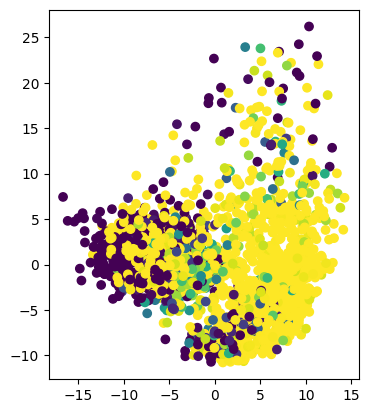

-----iteration--- 1


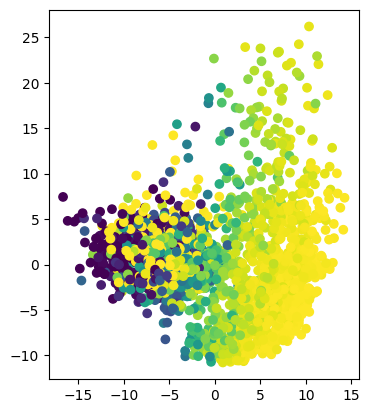

-----iteration--- 2


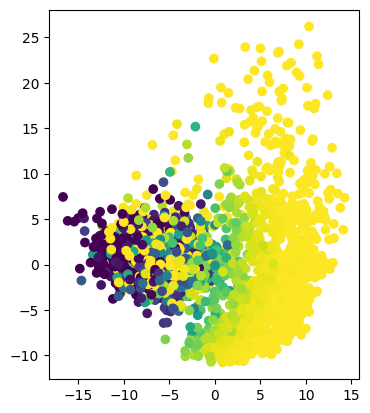

-----iteration--- 3


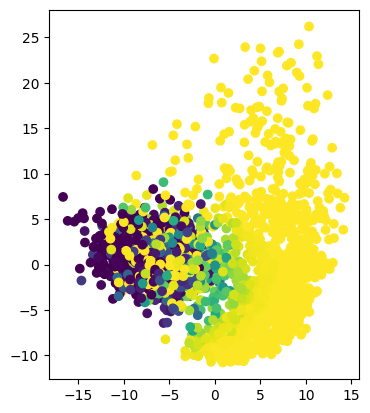

-----iteration--- 4


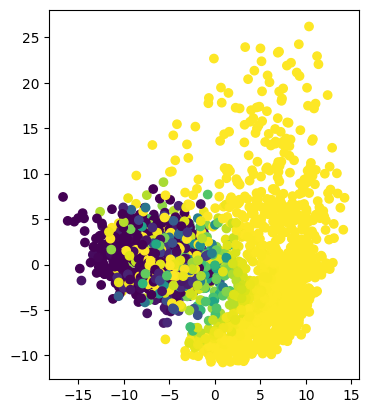

-----iteration--- 5


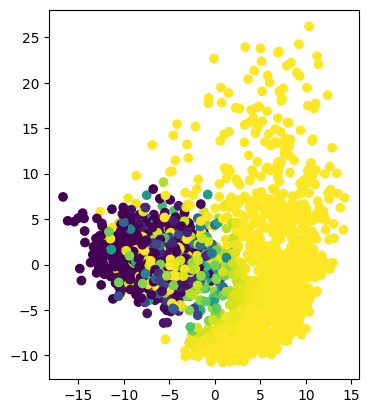

-----iteration--- 6


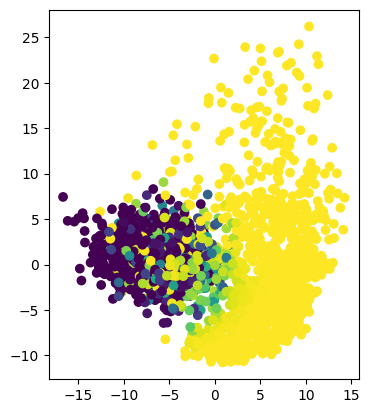

-----iteration--- 7


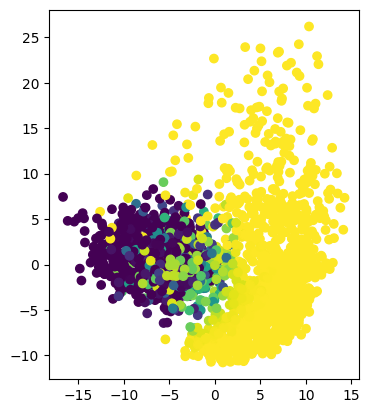

-----iteration--- 8


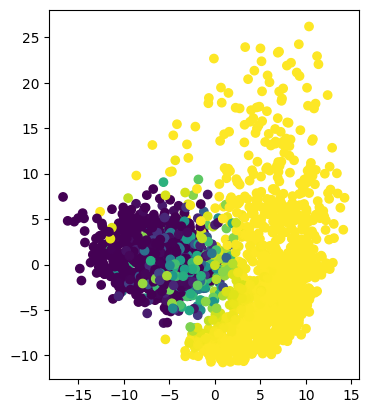

-----iteration--- 9


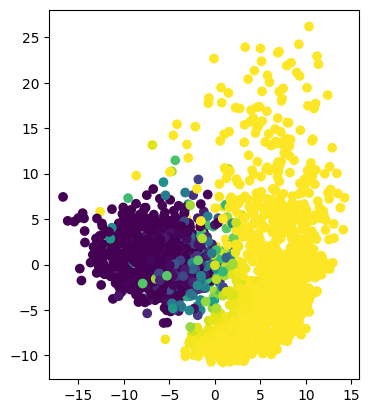

-----iteration--- 10


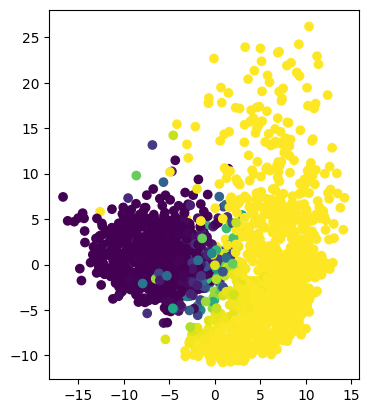

-----iteration--- 11


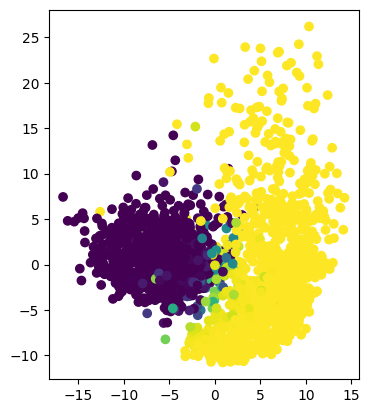

-----iteration--- 12


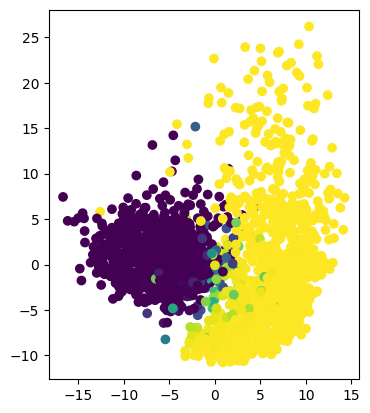

-----iteration--- 13


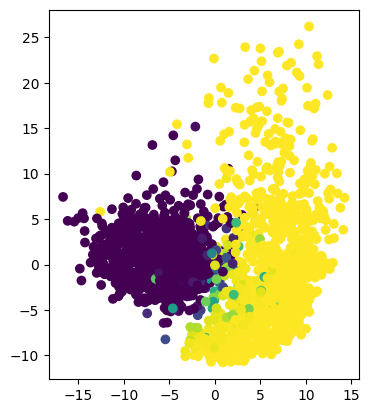

-----iteration--- 14


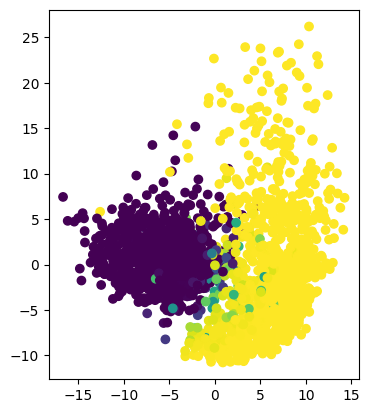

-----iteration--- 15


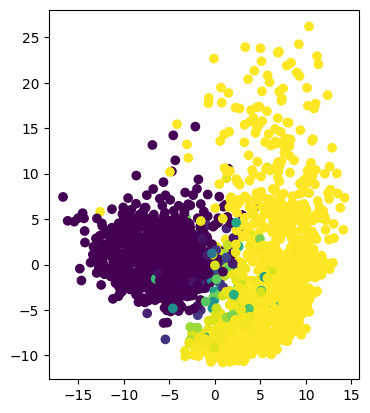

-----iteration--- 16


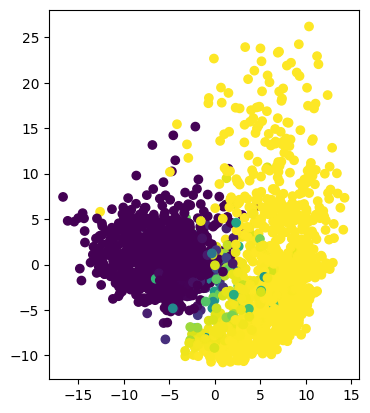

-----iteration--- 17


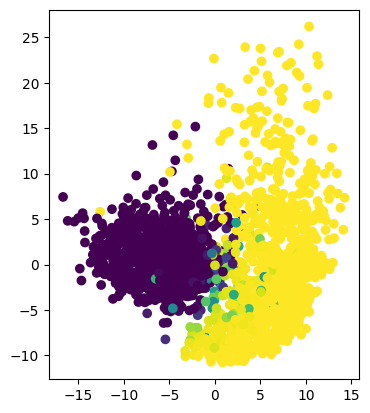

-----iteration--- 18


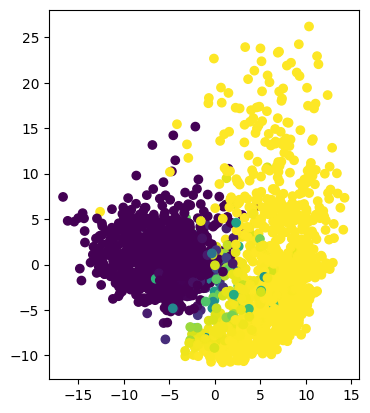

-----iteration--- 19


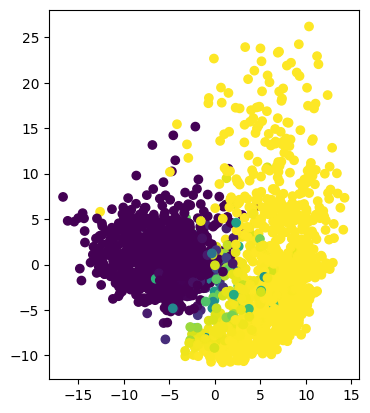

-----iteration--- 20


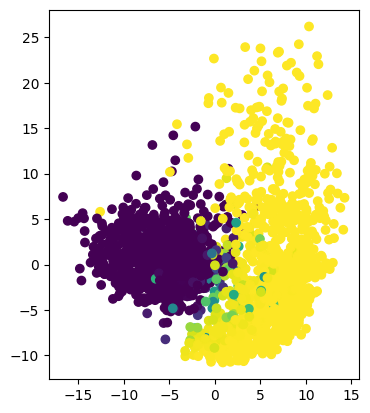

training coverged


In [323]:
# steps for implementing EM: following demo code

K = 2

seed = 123
np.random.seed(seed)

pi = np.random.random(K)
pi = pi/np.sum(pi)

# initialize mean and covariance
mu = np.random.randn(K,4)
mu_old = mu.copy()

sigma = []
for ii in range(K):
    # to ensure the covariance psd
    dummy = np.random.randn(4, 4)
    sigma.append(dummy@dummy.T + np.eye(4))
    
# initialize the posterior
tau = np.full((m, K), fill_value=0.)


# # parameter for countour plot
# xrange = np.arange(-5, -5, 0.1)
# yrange = np.arange(-5, -5, 0.1)

maxIter= 100
tol = 1e-3

# Metrics for log-likelihood
log_likelihood = []
iter_count = []

plt.ion()
    
for ii in range(100):

    # E-step    
    for kk in range(K):
        tau[:, kk] = pi[kk] * mvn.pdf(images_pca, mu[kk], sigma[kk])
    # normalize tau
    sum_tau = np.sum(tau, axis=1)
    sum_tau.shape = (m,1)    
    tau = np.divide(tau, np.tile(sum_tau, (1, K)))
    
    log_likelihood.append(np.sum(np.log(sum_tau)))
    # M-step
    for kk in range(K):
        # update prior
        pi[kk] = np.sum(tau[:, kk])/m
        
        # update component mean
        mu[kk] = images_pca.T @ tau[:,kk] / np.sum(tau[:,kk], axis = 0)
        
        # update cov matrix
        dummy = images_pca - np.tile(mu[kk], (m,1)) # X-mu
        sigma[kk] = dummy.T @ np.diag(tau[:,kk]) @ dummy / np.sum(tau[:,kk], axis = 0)
        
    iter_count.append(ii)
        
    print('-----iteration---',ii)    
    plt.scatter(images_pca[:,0], images_pca[:,1], c= tau[:,0])
    plt.axis('scaled')
    plt.savefig(f'./outputs/cluster-{ii}.png')
    plt.draw()
    plt.pause(0.1)
    
    plt.show()
    
    if np.linalg.norm(mu-mu_old) < tol:
        print('training coverged')
        break
    mu_old = mu.copy()
    
    if ii==99:
        print('max iteration reached')
        break

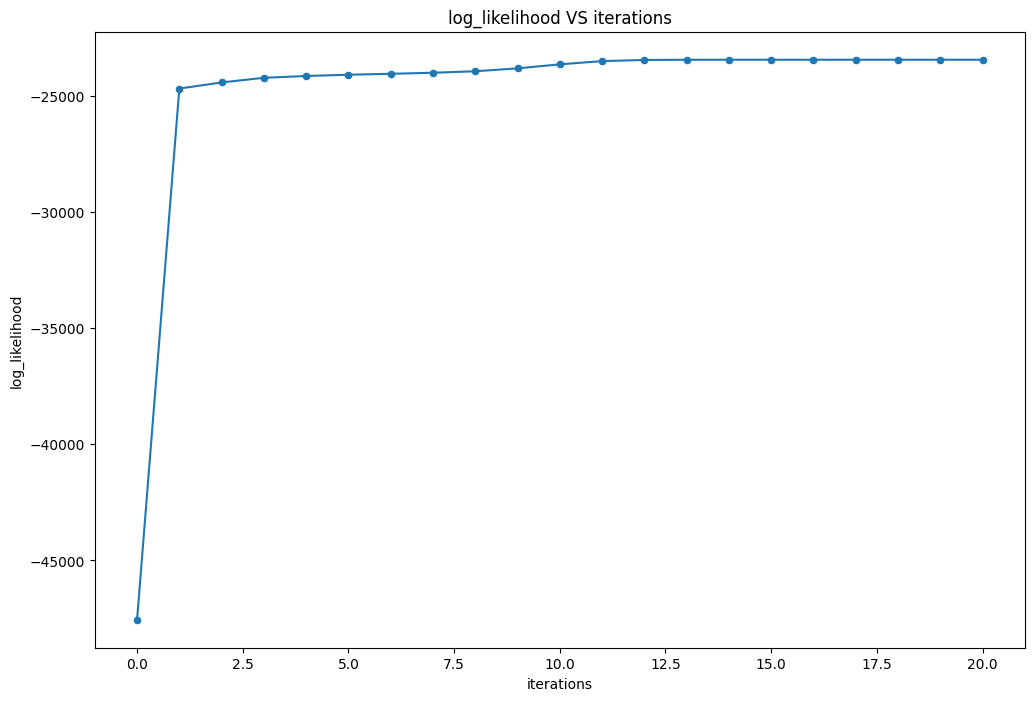

In [320]:
plt.figure(figsize = (12,8))
sns.lineplot(x=iter_count, y = log_likelihood)
sns.scatterplot(x = iter_count, y = log_likelihood)
plt.title('log_likelihood VS iterations')
plt.ylabel('log_likelihood')
plt.xlabel('iterations')
plt.savefig('./outputs/log-likelihood.png')
plt.show()

In [274]:
# Display numerical weights : note these are for gaussian components, do not confuse with pca dim reduction
print("Gaussian Component Weights:")
for i in range(K):
    print(f"Component {i+1}: {pi[i]}")

Gaussian Component Weights:
Component 1: 0.5043364819082853
Component 2: 0.49566351809171477


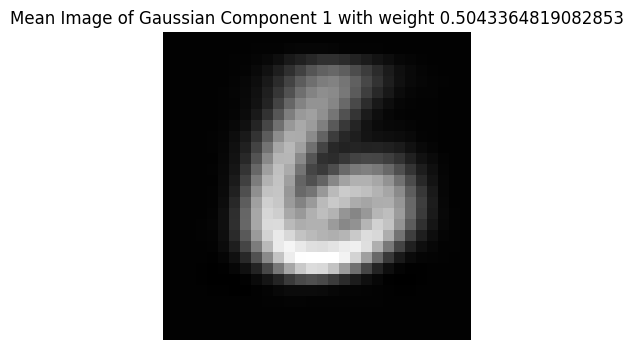

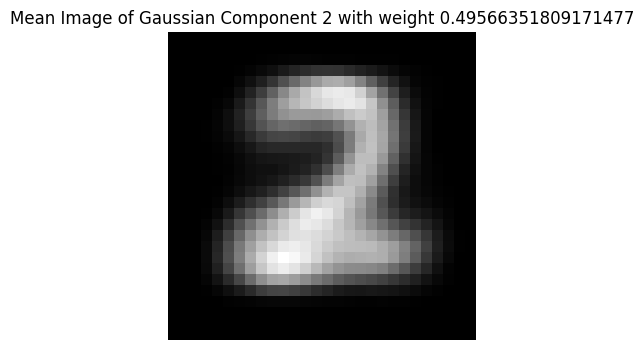

In [321]:
# Inverse PCA transformation to map the means back to original space (784 dimensions)
original_means = pca.inverse_transform(mu)
unscaled_means = scaler.inverse_transform(original_means)

# Reshape the means to 28x28 matrices (since each image is 28x28 pixels)
mean_images = unscaled_means.reshape(K, 28, 28, order = 'F')

# Visualize the mean images for each component
import matplotlib.pyplot as plt

for i in range(K):
    plt.figure(figsize=(4, 4))
    plt.imshow(mean_images[i], cmap='gray')
    plt.title(f"Mean Image of Gaussian Component {i+1} with weight {pi[i]}")
    plt.axis('off')
    plt.savefig(f'./outputs/mean-{i}.png')
    plt.show()

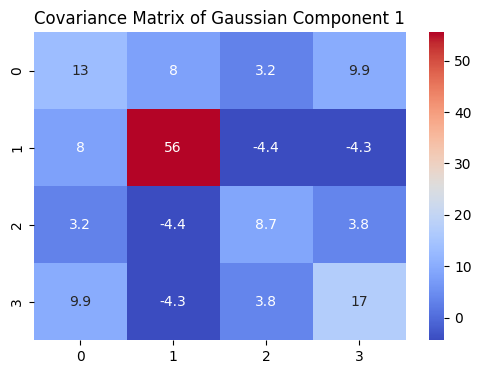

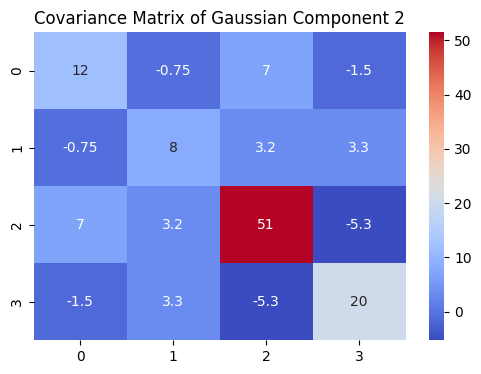

In [322]:
# Visualize the covariance matrices for each Gaussian component
for i in range(K):
    plt.figure(figsize=(6, 4))
    sns.heatmap(sigma[i], annot=True, cmap='coolwarm', cbar=True)
    plt.title(f"Covariance Matrix of Gaussian Component {i+1}")
    plt.savefig(f'./outputs/covariance-{i}.png')
    plt.show()

In [331]:

gmm_predicted_labels = np.argmax(tau, axis=1)


gmm_predicted_digits = np.where(gmm_predicted_labels == 0, 6, 2)


gmm_misclassification_rate = np.mean(gmm_predicted_digits != labels)


misclassified_2 = np.sum((gmm_predicted_digits != labels) & (labels == 2))
misclassified_6 = np.sum((gmm_predicted_digits != labels) & (labels == 6))

total_2 = np.sum(labels == 2)
total_6 = np.sum(labels == 6)

gmm_misclassification_rate_2 = misclassified_2 / total_2 if total_2 > 0 else 0
gmm_misclassification_rate_6 = misclassified_6 / total_6 if total_6 > 0 else 0


print(f"GMM Total Misclassification Rate: {gmm_misclassification_rate:.4f}")
print(f"GMM Misclassification Rate for '2': {gmm_misclassification_rate_2:.4f}")
print(f"GMM Misclassification Rate for '6': {gmm_misclassification_rate_6:.4f}")

GMM Total Misclassification Rate: 0.0372
GMM Misclassification Rate for '2': 0.0601
GMM Misclassification Rate for '6': 0.0125


In [332]:
# Use K-means on the original data
kmeans = KMeans(n_clusters=2, random_state=seed)
kmeans_labels = kmeans.fit_predict(images_pca)

# Map predicted labels to actual digits
kmeans_predicted_digits = np.where(kmeans_labels == 0, 6, 2)

# Calculate total misclassification rate
kmeans_misclassification_rate = np.mean(kmeans_predicted_digits != labels)

# Calculate misclassification rates for '2' and '6'
misclassified_2 = np.sum((kmeans_predicted_digits != labels) & (labels == 2))
misclassified_6 = np.sum((kmeans_predicted_digits != labels) & (labels == 6))

total_2 = np.sum(labels == 2)
total_6 = np.sum(labels == 6)

kmeans_misclassification_rate_2 = misclassified_2 / total_2 if total_2 > 0 else 0
kmeans_misclassification_rate_6 = misclassified_6 / total_6 if total_6 > 0 else 0

# Print the results
print(f"K-means Total Misclassification Rate: {kmeans_misclassification_rate:.4f}")
print(f"K-means Misclassification Rate for '2': {kmeans_misclassification_rate_2:.4f}")
print(f"K-means Misclassification Rate for '6': {kmeans_misclassification_rate_6:.4f}")

K-means Total Misclassification Rate: 0.0543
K-means Misclassification Rate for '2': 0.0746
K-means Misclassification Rate for '6': 0.0324


In [292]:
if gmm_misclassification_rate < kmeans_misclassification_rate:
    print("GMM performs better.")
else:
    print("K-means performs better.")

GMM performs better.
